# Joint flight data — first look

In [1]:
from setup   import *
from netCDF4 import Dataset
import glob

In [2]:
files = glob.glob("../data/*.nc")
halo_mw     = Dataset(glob.glob("../data/*nawd*mwr*.nc")[0],    "r")
halo_radar  = Dataset(glob.glob("../data/*nawd*cr*.nc")[0],     "r")
halo_sonde  = Dataset(glob.glob("../data/*nawd*sonde*.nc")[0],  "r")
rasta_radar = Dataset(glob.glob("../data/NAWDEX*RASTA*.nc")[0], "r")
faam_ismar  = Dataset(glob.glob("../data/metoffice-ismar_faam*.nc")[0], "r")

### HAMP RADAR data

For the HALO aircraft, the joined leg of the flight campaign lasted from 9:51 to 10:16 UTC. Here we extract the start and end time of the leg in seconds passed sind the reference data first of January 1970.

In [5]:
from datetime import datetime

t0 = datetime(year = 1970, month = 1, day = 1, hour = 0, minute = 0, second = 0)
t1 = datetime(year = 2016, month = 10, day = 14, hour = 9, minute = 51, second = 30)
t2 = datetime(year = 2016, month = 10, day = 14, hour = 10, minute = 15, second = 30)

dt_start = (t1 - t0).total_seconds()
dt_end   = (t2 - t0).total_seconds()

In [6]:
halo_times = halo_radar["time"][:]
i_start = np.where(halo_times >= dt_start)[0][0]
i_end   = np.where(halo_times >  dt_end)[0][0]

hamp_dbz = halo_radar["dbz"][i_start : i_end]
hamp_lat = halo_radar["lat"][i_start : i_end]
hamp_lon = halo_radar["lon"][i_start : i_end]
hamp_z   = halo_radar.variables["height"][:]

We define the coordinates of the first HAMP radar profile as reference coordinates. These will be used to convert the other coordinates to a rectilinear coordinate system within which the collocation will be performed.

In [7]:
lat_r = hamp_lat[0]
lon_r = hamp_lon[0]

In [11]:
from geopy import distance as dist
hamp_d = np.zeros(hamp_lat.shape)
for i in range(hamp_d.size):
    hamp_d[i] = dist.vincenty((lat_r, lon_r), (hamp_lat[i], hamp_lon[i])).km

### HALO Sondes


In [12]:
halo_sonde.variables['sonde_number'][:]
sonde_z   = halo_sonde.variables["height"][:]

sonde_lat_m = halo_sonde.variables["lat"][:]
sonde_lon_m = halo_sonde.variables["lon"][:]
sonde_p_m   = halo_sonde.variables["pa"][:]
sonde_rh_m  = halo_sonde.variables["hur"][:]
sonde_d_m = np.zeros(sonde_lat_m.shape)

sonde_lat = np.zeros(sonde_lat_m.shape)
sonde_lon = np.zeros(sonde_lat_m.shape)
sonde_p   = np.zeros(sonde_lat_m.shape)
sonde_rh  = np.zeros(sonde_lat_m.shape)
sonde_d   = np.zeros(sonde_lat_m.shape)

for i in range(sonde_lat.shape[0]):
    
    mask = sonde_lat_m.mask
    m = np.logical_not(mask[i, :])
    sonde_lat[i, :] = np.interp(sonde_z, sonde_z[m], sonde_lat_m[i, m])
    
    mask = sonde_lon_m.mask
    m = np.logical_not(mask[i, :])
    sonde_lon[i, :] = np.interp(sonde_z, sonde_z[m], sonde_lon_m[i, m])
    
    mask = sonde_p_m.mask
    m = np.logical_not(mask[i, :])
    sonde_p[i, :]   = np.interp(sonde_z, sonde_z[m], sonde_p_m[i, m])
    
    mask = sonde_rh_m.mask
    m = np.logical_not(mask[i, :])
    sonde_rh[i, :]  = np.interp(sonde_z, sonde_z[m], sonde_rh_m[i, m])
    
    
for i in range(sonde_d.shape[0]):
    for j in range(sonde_d[i, :].size):
        sonde_d[i, j] = dist.vincenty((lat_r, lon_r), (sonde_lat[i, j], sonde_lon[i, j])).km
        

for i in range(sonde_d.shape[0]):
    m = sonde_d[i, :] < 1000.0
    sonde_d[i, :]  = np.interp(sonde_z, sonde_z[m], sonde_d[i, m])
    
# Sort sondes

inds = np.argsort(sonde_d[:, 0])
sonde_d = sonde_d[inds, :]

### Rasta data
For the Falcon aircraft, the time is given in hours since midnight so determining the start and end points of the joint flight is simpler.

In [13]:
from datetime import datetime

t_start = 9  + 50 / 60
t_end   = 10 + 21 / 60

In [14]:
rasta_times = rasta_radar["time"][:]
i_start = np.where(rasta_times >= t_start)[0][0]
i_end   = np.where(rasta_times >  t_end)[0][0]

rasta_dbz = rasta_radar["Z"][i_start : i_end, :]
rasta_lat = rasta_radar["latitude"][i_start : i_end]
rasta_lon = rasta_radar["longitude"][i_start : i_end]
altitude  = rasta_radar.variables["altitude"][i_start : i_end]
rasta_z   = rasta_radar.variables["height_2D"][i_start : i_end, :]
rasta_d = np.zeros(rasta_lat.shape)
for i in range(rasta_d.size):
    rasta_d[i] = dist.vincenty((lat_r, lon_r), (rasta_lat[i], rasta_lon[i])).km

## Ismar data

In [16]:
ismar_time = faam_ismar.variables["time"][:]
i_start = np.where(ismar_time / 3600 > 9.81)[0][0]
i_end   = np.where(ismar_time / 3600 >  10.35)[0][0]

ismar_angles = faam_ismar.variables["angle"][i_start : i_end]
indices = ismar_angles == 0
ismar_lat = faam_ismar.variables["latitude"][i_start : i_end][indices]
ismar_lon = faam_ismar.variables["longitude"][i_start : i_end][indices]
ismar_tbs = faam_ismar.variables["brightness_temperature"][i_start : i_end, :][indices]
ismar_pes = faam_ismar.variables["brightness_temperature_positive_error"][i_start : i_end, :][indices]
ismar_nes = faam_ismar.variables["brightness_temperature_negative_error"][i_start : i_end, :][indices]
#ismar_tbs += ismar_nes - ismar_pes
ismar_channels = np.array([1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 6, 6, 8, 8])
ismar_d = np.zeros(ismar_lat.shape)
for i in range(ismar_d.size):
    ismar_d[i] = dist.vincenty((lat_r, lon_r), (ismar_lat[i], ismar_lon[i])).km

Since the ISMAR data is very noisy we apply sligin window averaging

In [30]:
ismar_tbs[:, -5]

array([ 1.45196609e+02, -1.18284546e+02,  1.03202545e+02,  6.65833435e+01,
        7.27997494e+00,  7.88711472e+01, -1.05965014e+01,  3.75920258e+01,
       -1.01177910e+02,  2.05076675e+01, -3.89970932e+01, -8.78082943e+00,
        1.17061127e+02,  1.37738617e+02,  1.13838768e+02,  5.73583107e+01,
        3.44870148e+01,  1.03770126e+02,  6.32343102e+01,  5.87451019e+01,
        3.96965828e+01, -1.81540051e+01, -6.44646225e+01, -9.73031082e+01,
        7.31050644e+01,  1.63589458e+01,  1.32333679e+02,  1.24474861e+02,
       -4.85540962e+01, -7.25440502e+00,  1.28866333e+02,  1.55073837e+02,
        6.15695763e+01,  1.71928314e+02,  3.19948406e+01, -6.16162643e+01,
       -1.08031609e+02,  1.67332199e+02, -1.00141464e+02, -1.16810980e+01,
       -5.21909676e+01, -4.63577652e+00, -6.76413422e+01,  2.59917808e+00,
       -1.99147278e+02,  1.97771225e+01, -1.69948540e+01, -9.28231354e+01,
        1.14829308e+02, -1.55575867e+02,  7.80412445e+01, -2.53760700e+01,
        9.62581100e+01, -

In [31]:
import scipy
from scipy.ndimage.filters import convolve1d

width = 10
weights = np.ones(width) / width
for i in range(ismar_tbs.shape[1]):
    ismar_tbs[:, i] = convolve1d(ismar_tbs[:, i], weights, mode = "reflect")

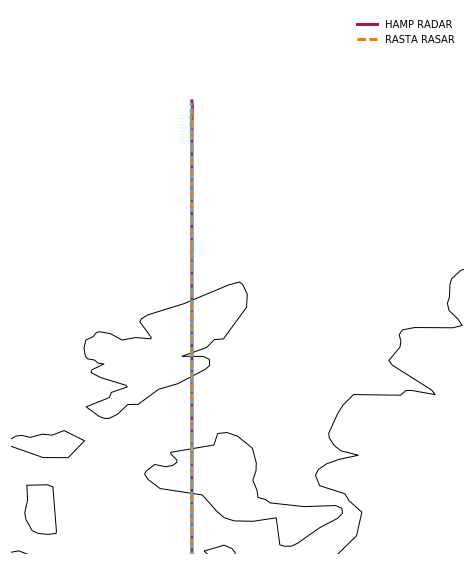

In [32]:
import cartopy.crs as ccrs
fig = plt.figure(figsize = (10, 10))
ax  = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.plot(hamp_lon, hamp_lat, label = "HAMP RADAR", lw = 3)
ax.plot(rasta_lon, rasta_lat, label = "RASTA RASAR", lw = 3, ls = "--")
ax.plot(ismar_lon, ismar_lat, lw = 3, ls = ":")

ax.coastlines(resolution = "50m", linewidth = 1)
ax.set_xlim([-7.5, -5])
ax.set_ylim([57, 60])
ax.legend()

In [33]:
np.where(sonde_d > 1000)[1]

array([], dtype=int64)

In [34]:
ismar_tbs.shape

(530, 21)

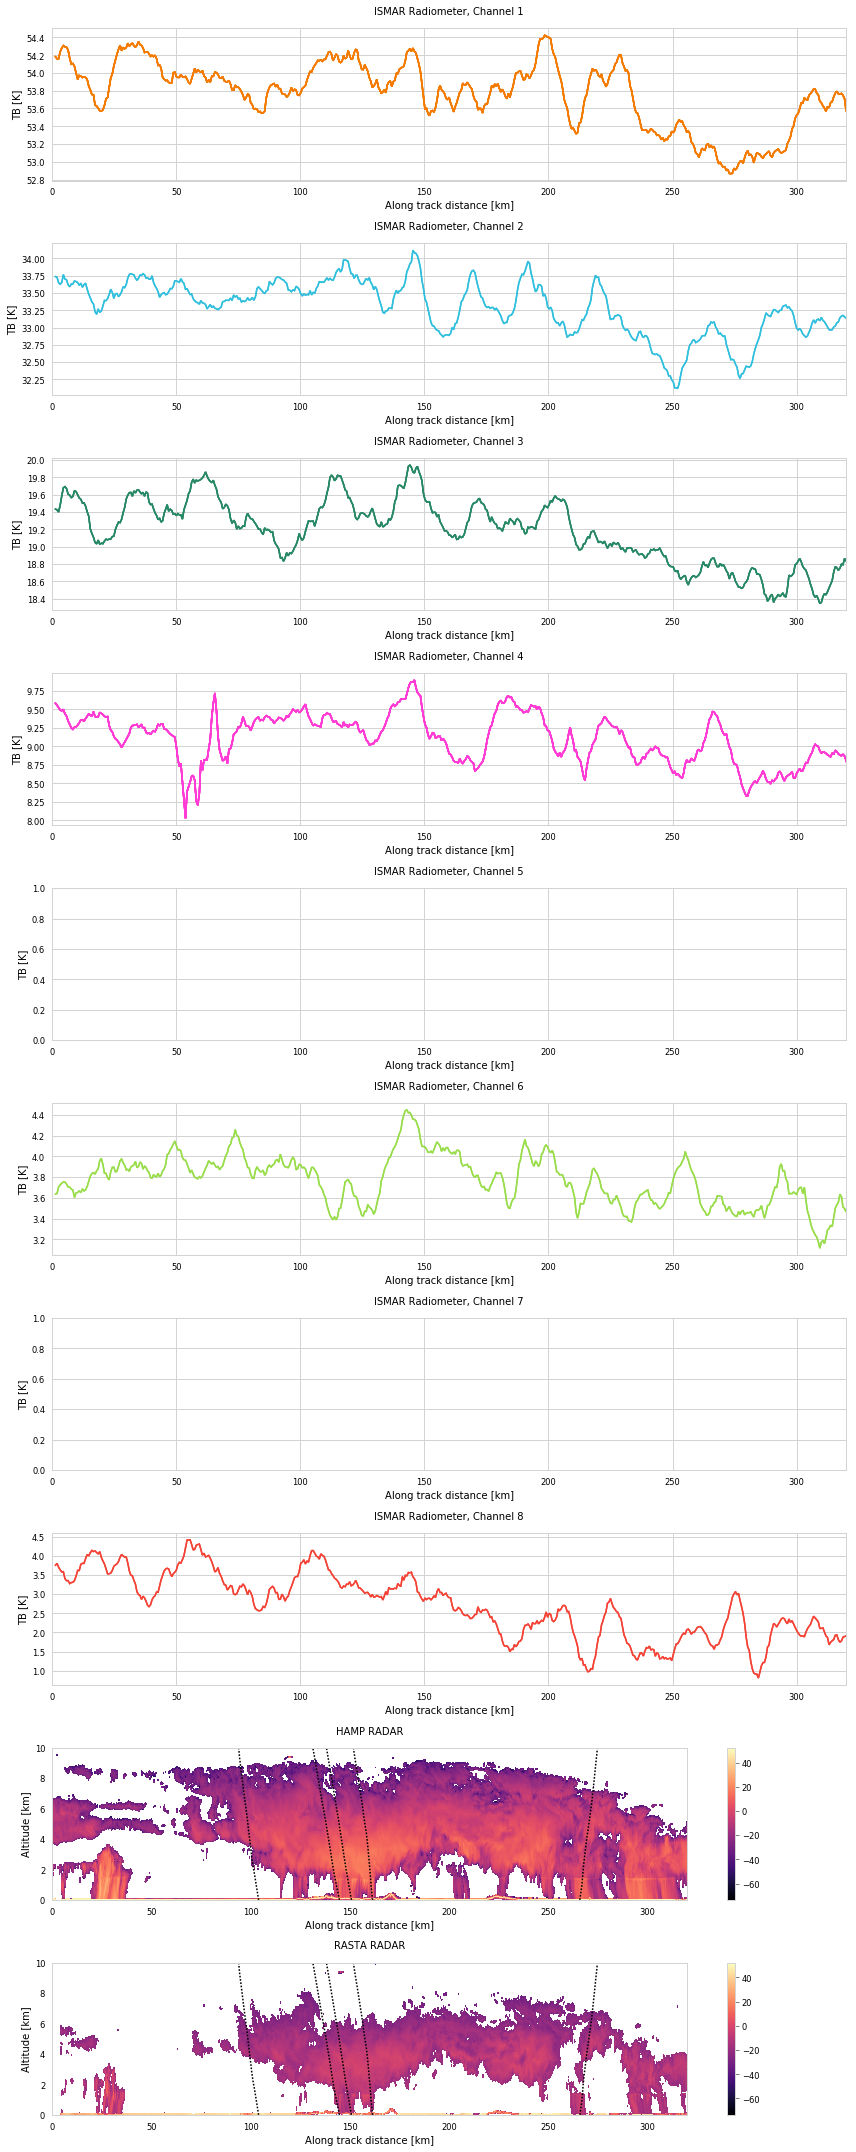

In [54]:
f, axs = plt.subplots(10, 1, figsize = (12, 30))

for i in range(1, 9):
    ax = axs[i - 1]
    for j, c in enumerate(ismar_channels):
        if c == i:
            ax.plot(ismar_d, ismar_tbs[:, i], c = "C" + str(c))
    ax.set_title("ISMAR Radiometer, Channel " + str(i))
    ax.set_xlabel("Along track distance [km]")
    ax.set_ylabel("TB [K]")
    #ax.set_ylim([0, 600])
    ax.set_xlim([0, 320])

ax = axs[8]
img = ax.pcolormesh(hamp_d, hamp_z[:] / 1e3, hamp_dbz.T)
f.colorbar(img, ax = ax)
for i in range(sonde_d.shape[0]):
    ax.plot(sonde_d[i, :], sonde_z / 1e3, c = "k", ls = ":")
ax.set_title("HAMP RADAR")
ax.set_xlabel("Along track distance [km]")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 10])
ax.set_xlim([0, 320])


ax = axs[9]
ax.pcolormesh(np.broadcast_to(rasta_d.reshape(-1, 1), (rasta_z.shape)),
                rasta_z, rasta_dbz[:, :])
for i in range(sonde_d.shape[0]):
    ax.plot(sonde_d[i, :], sonde_z / 1e3, c = "k", ls = ":")
f.colorbar(img, ax = ax)
ax.set_title("RASTA RADAR")
ax.set_xlabel("Along track distance [km]")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 10])
ax.set_xlim([0, 320])

plt.tight_layout()

## Data processing

### Background atmosphere

For the background atmospheric state, the following variables are extracted from the HALO drop sonde data:

- Pressure
- Altitude
- Relative humidity

In [141]:
pressure = np.zeros((hamp_d.size, hamp_z.size))
humidity = np.zeros((hamp_d.size, hamp_z.size))
altitude = np.broadcast_to(hamp_z.reshape(1, -1), pressure.shape)

for i in range(hamp_z.size):
    pressure[:, i] = np.interp(hamp_d, sonde_d[:, i], sonde_p[:, i])
    humidity[:, i] = np.interp(hamp_d, sonde_d[:, i], sonde_rh[:, i])

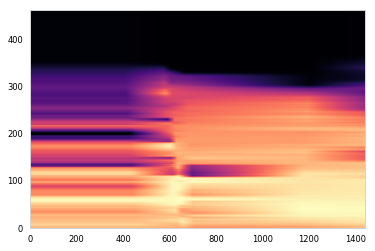

In [142]:
plt.pcolormesh(humidity.T)

### RADAR data

We use the HALO data as is and interpolate the RASTA data to the corresponding along track distance.
We also replace mask values by the noise thresh

In [177]:
inds = y_rasta > -200
y_rasta[inds].min()

-199.84001110532654

In [208]:
y_hamp = -35 * np.ones(hamp_dbz.shape)
m = np.logical_not(hamp_dbz.mask)
y_hamp[m] = hamp_dbz[m] - 7.6
y_rasta = -35 * np.ones((y_hamp.shape[0], rasta_dbz.shape[1]))
rasta_dbz[rasta_z <= 0.0] = -35
for i in range(rasta_dbz.shape[1]):
    m = rasta_dbz.mask[:, i]
    rasta_dbz_no_mask = rasta_dbz[:, i]
    rasta_dbz_no_mask[m] = -35
    y_rasta[:, i] = np.interp(hamp_d, rasta_d, rasta_dbz[:, i])

In [203]:
y_rasta.min()

-42.52659422594255

In [204]:
rasta_dbz

masked_array(
  data=[[-35.0, -35.0, -35.0, ..., -35.0, -35.0, -35.0],
        [-35.0, -35.0, -35.0, ..., -35.0, -35.0, -35.0],
        [-35.0, -35.0, -35.0, ..., -35.0, -35.0, -35.0],
        ...,
        [-35.0, -35.0, -35.0, ..., -35.0, -35.0, -35.0],
        [-35.0, -35.0, -35.0, ..., -35.0, -35.0, -35.0],
        [-35.0, -35.0, -35.0, ..., -35.0, -35.0, -35.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=-999.0,
  dtype=float32)

array([[11.166939 , 11.106939 , 11.046939 , ..., -3.653061 , -3.7130613,
        -3.7730608],
       [11.165781 , 11.105782 , 11.045781 , ..., -3.6542187, -3.714219 ,
        -3.7742186],
       [11.1646385, 11.104639 , 11.044639 , ..., -3.6553612, -3.7153616,
        -3.775361 ],
       ...,
       [11.131625 , 11.071626 , 11.011625 , ..., -3.6883745, -3.748375 ,
        -3.8083744],
       [11.131381 , 11.071382 , 11.011381 , ..., -3.6886187, -3.748619 ,
        -3.8086185],
       [11.131152 , 11.071153 , 11.011152 , ..., -3.6888475, -3.748848 ,
        -3.8088474]], dtype=float32)

In [216]:
z2d = rasta_radar.variables["height_2D"][i_start : i_end, :]

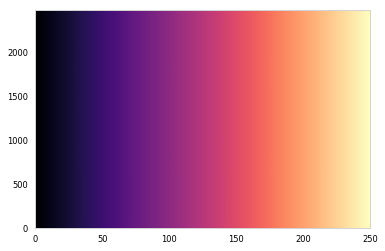

In [218]:
plt.pcolormesh(z2d - rasta_z)

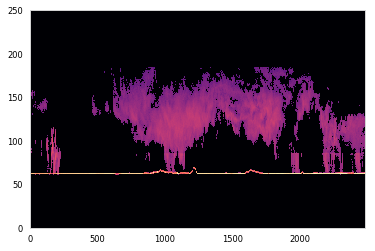

In [209]:
plt.pcolormesh(rasta_dbz.T)

In [167]:
root = Dataset("../data/retrieval_input.nc", "w")


In [169]:
t  = root.createDimension("time", y_hamp.shape[0])
z  = root.createDimension("altitude", hamp_z.size)
rr = root.createDimension("rasta_range_bins", rasta_dbz.shape[1])

In [172]:
p    = root.createVariable("pressure", "f8", dimensions = ("time", "altitude"))
p[:] = pressure
a = root.createVariable("altitude", "f8", dimensions = ("time", "altitude"))
a[:] = altitude
rh    = root.createVariable("humidity", "f8", dimensions = ("time", "altitude"))
rh[:] = humidity